# Load and preprocess

In [9]:
import pandas as pd
import numpy as np
import re
import logging
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    adjusted_mutual_info_score
)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data = pd.read_csv('../../data/processed_dataFinale.csv')


In [11]:

data['processed_text'] = data['processed_text'].apply(ast.literal_eval)

data['processed_text_str'] = data['processed_text'].apply(lambda tokens: ' '.join(tokens))


In [12]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to top 1000 features
tfidf_features = tfidf.fit_transform(data['processed_text_str'])

tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out(), index=data.index)


In [13]:
data['text_length'] = data['processed_text_str'].apply(len)


In [14]:
data['unique_word_ratio'] = data['processed_text'].apply(
    lambda tokens: len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0
)
categories = pd.get_dummies(data['category'], prefix='category')
features = pd.concat([
    tfidf_df,
    data[['text_length', 'unique_word_ratio', 'rating']].reset_index(drop=True),
    categories.reset_index(drop=True)
], axis=1)


In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=0.95, random_state=42)  # 95% variance
pca_features = pca.fit_transform(scaled_features)
print(f'Original number of features: {scaled_features.shape[1]}')
print(f'Reduced number of features after PCA: {pca_features.shape[1]}')

Original number of features: 1013
Reduced number of features after PCA: 918


# Clustering

Preforming clustering for k = 2: 
Davies-Bouldin Index: 6.6128
Contingency Table:
label       CG     OR
cluster              
0        20141  19784
1           75    432


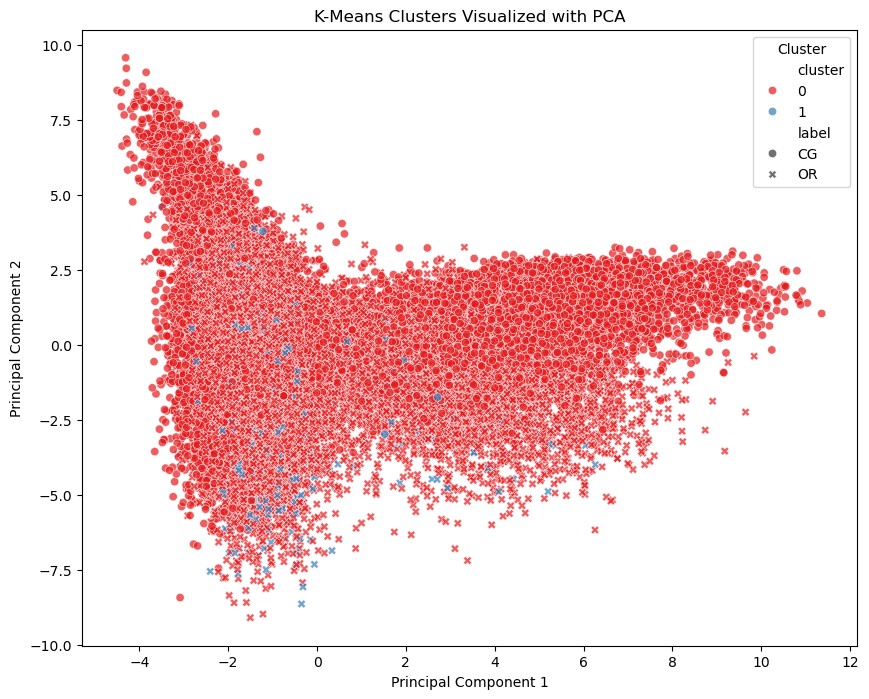

Preforming clustering for k = 3: 
Davies-Bouldin Index: 6.3823
Contingency Table:
label       CG     OR
cluster              
0        20003  19583
1           75    430
2          138    203


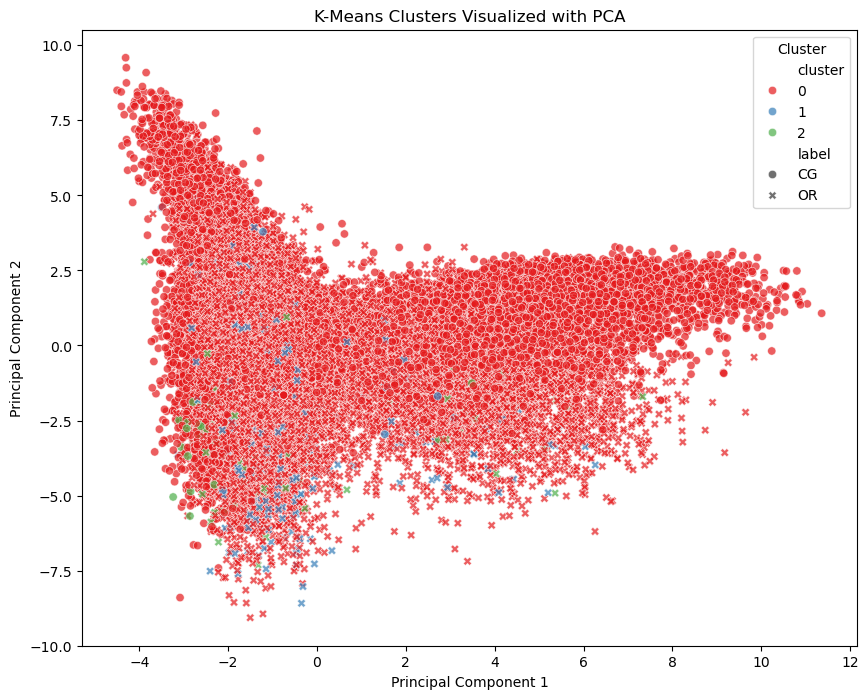

Preforming clustering for k = 4: 
Davies-Bouldin Index: 8.1620
Contingency Table:
label       CG     OR
cluster              
0         6015   5720
1           30    226
2          136    192
3        14035  14078


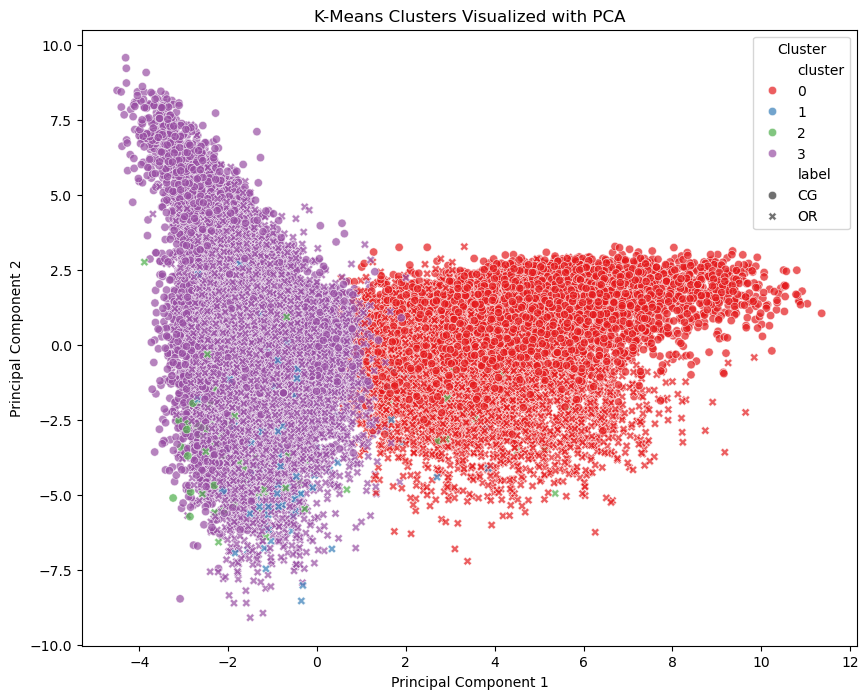

Preforming clustering for k = 5: 
Davies-Bouldin Index: 8.5233
Contingency Table:
label       CG     OR
cluster              
0         6061   5772
1           30    225
2          136    190
3        12088  12201
4         1901   1828


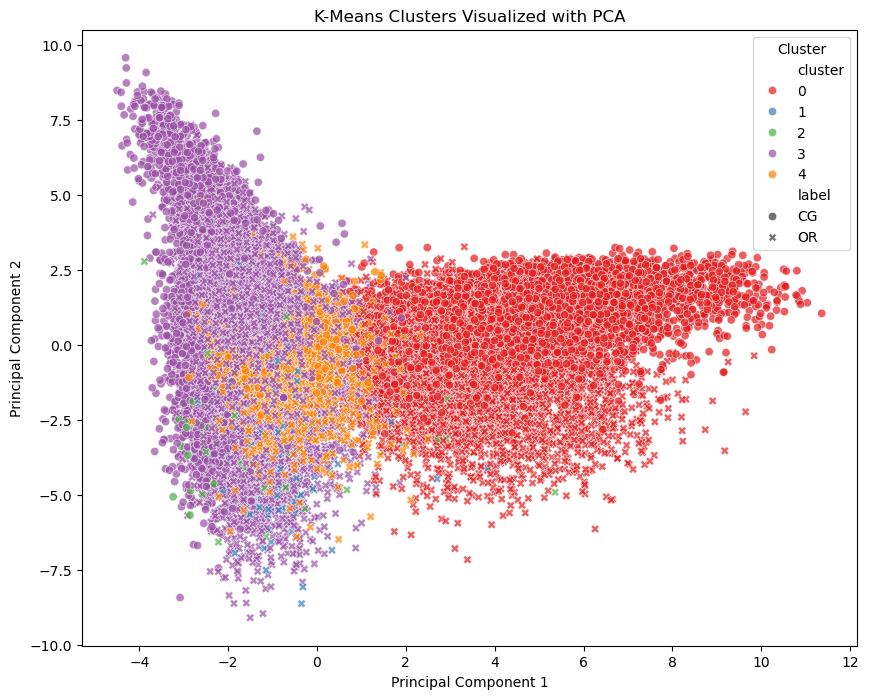

Preforming clustering for k = 6: 
Davies-Bouldin Index: 7.6014
Contingency Table:
label       CG     OR
cluster              
0         6058   5771
1           30    224
2          135    187
3        12079  12155
4         1883   1815
5           31     64


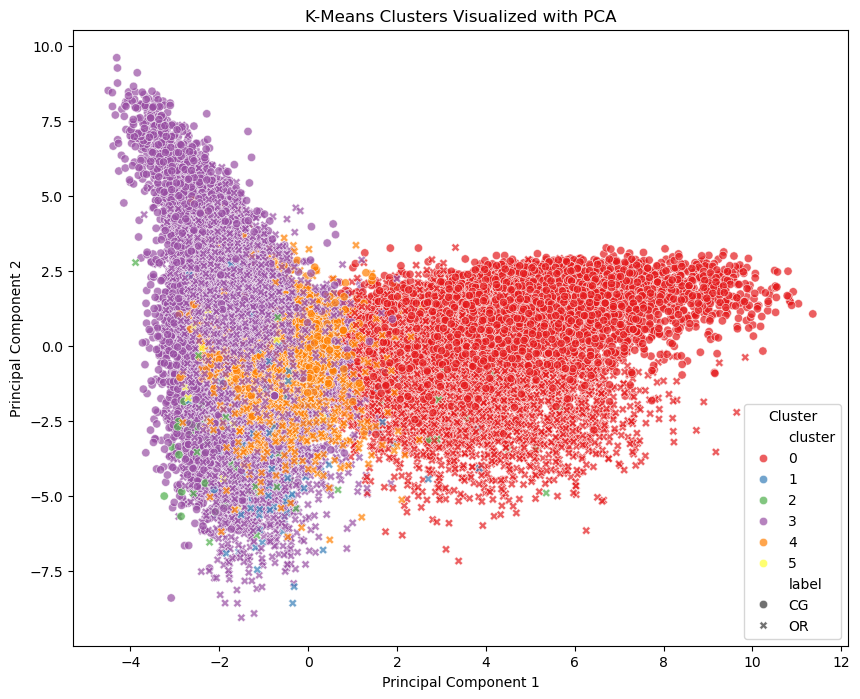

Preforming clustering for k = 7: 
Davies-Bouldin Index: 7.0601
Contingency Table:
label       CG     OR
cluster              
0         6059   5747
1           30    223
2          134    186
3        12070  12078
4         1883   1809
5           31     63
6            9    110


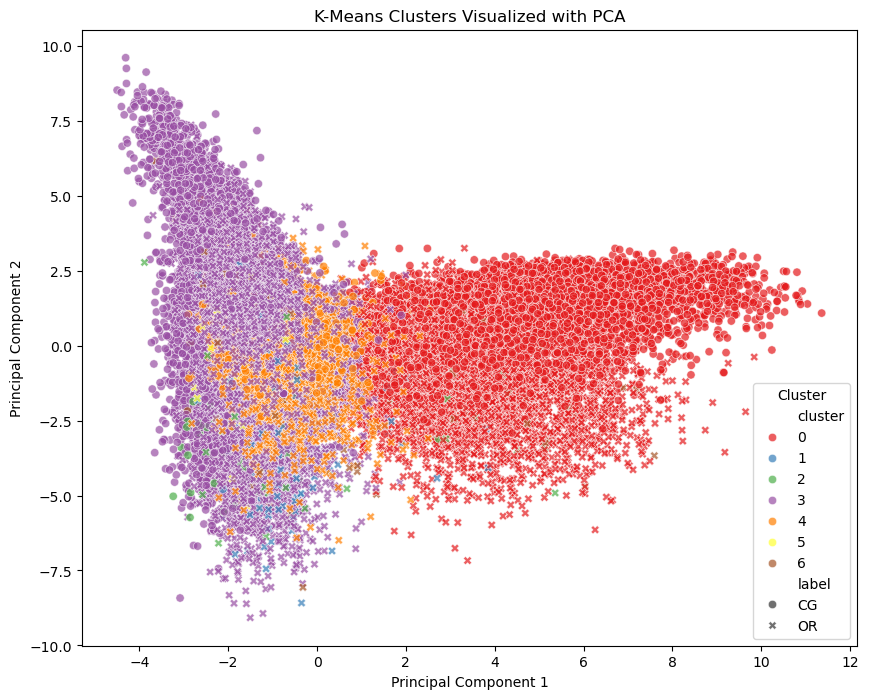

Preforming clustering for k = 8: 
Davies-Bouldin Index: 6.5895
Contingency Table:
label       CG     OR
cluster              
0        11994  12015
1           29    223
2         1884   1747
3           24     63
4           23     99
5         5597   5709
6           27     95
7          638    265


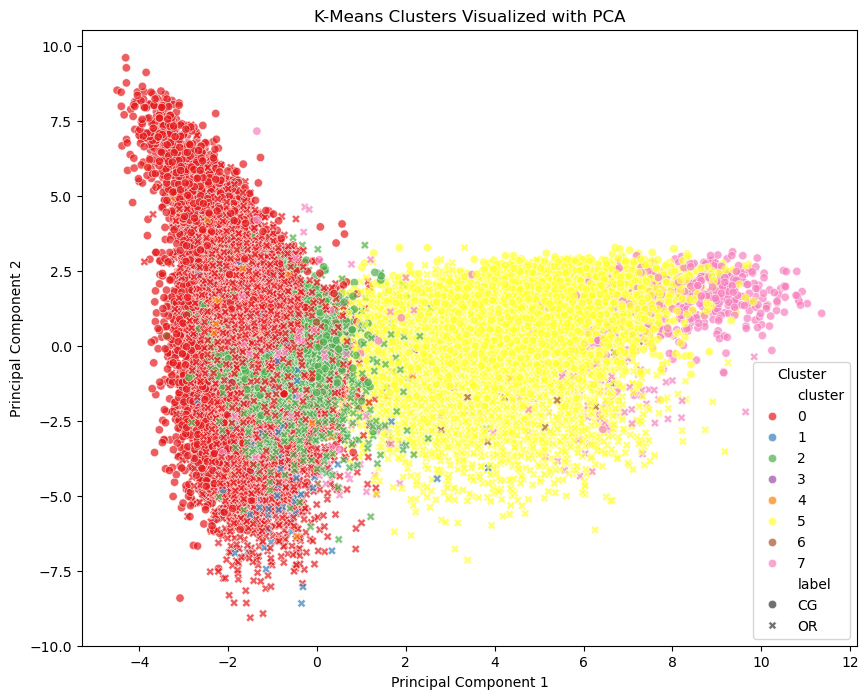

Preforming clustering for k = 9: 
Davies-Bouldin Index: 6.5895
Contingency Table:
label       CG     OR
cluster              
0        11974  11982
1           29    221
2         1877   1739
3           24     63
4           23     99
5         1702   1631
6           27     93
7          625    263
8         3935   4125


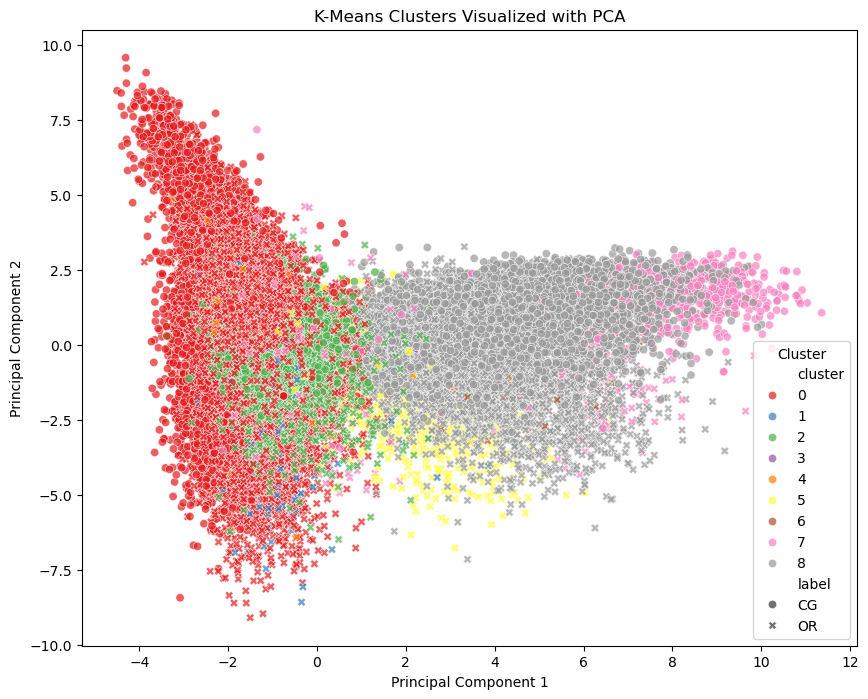

Preforming clustering for k = 10: 
Davies-Bouldin Index: 6.8626
Contingency Table:
label       CG     OR
cluster              
0        10046  10469
1           29    216
2         1861   1717
3           24     63
4           23     98
5         1703   1638
6           27     92
7          623    258
8         3937   4125
9         1943   1540


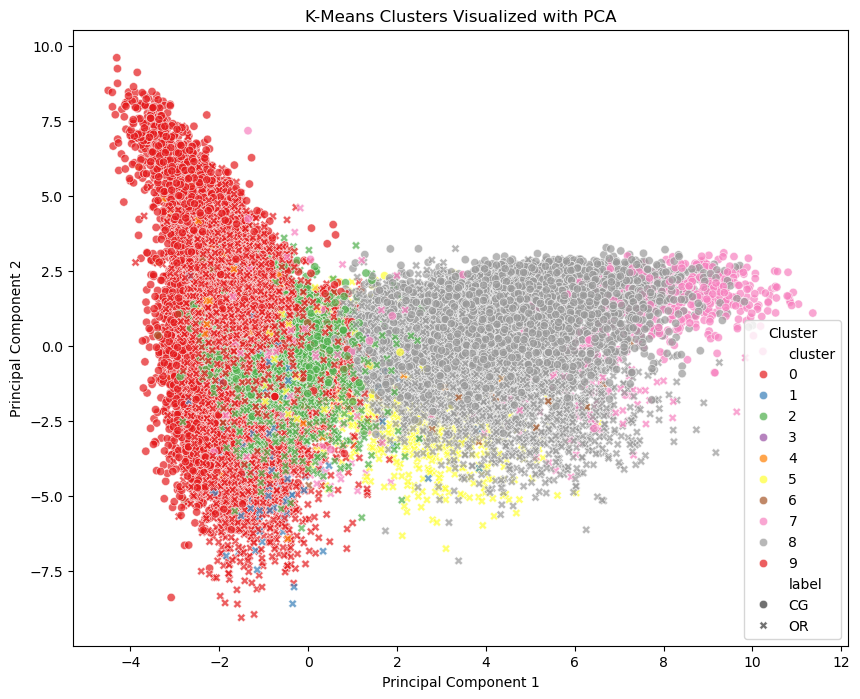

In [18]:
ks = np.linspace(2,10,9)
db_scores = []
results = []
for k in ks:

    k = int(k)
    print(f'Preforming clustering for k = {k}: ')
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)

    data['cluster'] = cluster_labels

    davies_bouldin = davies_bouldin_score(pca_features, cluster_labels)
    print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')
    db_scores.append(davies_bouldin)
    contingency_table = pd.crosstab(data['cluster'], data['label'])
    print('Contingency Table:')
    print(contingency_table)


    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(pca_features)
    data['pc1'] = principal_components[:, 0]
    data['pc2'] = principal_components[:, 1]


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='pc1', y='pc2',
        hue='cluster',
        style='label',  
        palette='Set1',
        data=data,
        alpha=0.7
    )
    plt.title('K-Means Clusters Visualized with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()

    results.append({
        'k': k,
        'davies_bouldin_index': davies_bouldin,
        'contingency_table': contingency_table.to_string()
    })

results_df = pd.DataFrame(results)
results_df.to_csv('clustering_results.csv', index=False)




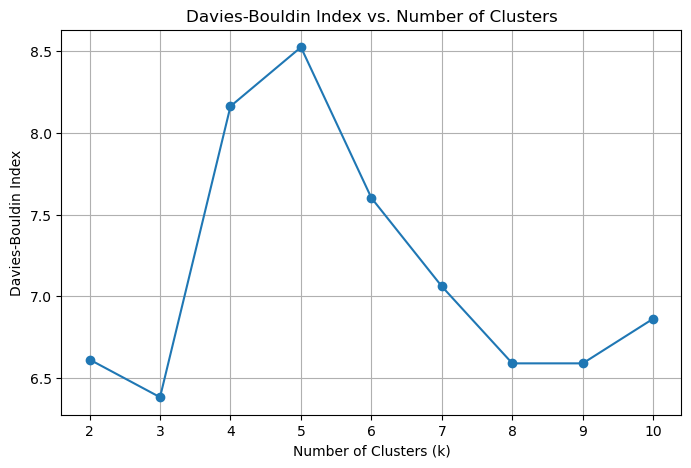

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(ks, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.savefig('davies_bouldin_vs_k.png')
plt.show()




In [23]:
metrics_df = pd.DataFrame({
    'Number of Clusters (k)': ks,
    'Davies-Bouldin Index': db_scores
})

metrics_df.to_csv('evaluation_metrics.csv', index=False)

print(metrics_df)


   Number of Clusters (k)  Davies-Bouldin Index
0                     2.0              6.612772
1                     3.0              6.382339
2                     4.0              8.162011
3                     5.0              8.523262
4                     6.0              7.601357
5                     7.0              7.060087
6                     8.0              6.589475
7                     9.0              6.589485
8                    10.0              6.862591
